In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [3]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

# def flatten(x, y, return_trend=False):
#     m = y < np.percentile(y, 95)
#     p = np.polyfit(x[m], y[m], 3)
#     if return_trend:
#         return y / np.polyval(p, x), np.polyval(p, x)
#     return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)
    
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

from scipy.optimize import minimize

def model(theta, x):
    a, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + 0#c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y))
    return res

In [59]:
def clean_spectrum(wav, flux, template, wav_shift=0):
    all_w, all_f = [], []
    wav_max = 0
    for w, f in zip(wav[:], flux[:]):
        m = (np.log(f) > 0)# & (f < 5*np.std(f))
        w, f = w[m][8:-8], f[m][8:-8]
#         plt.plot(w,f)
#         w = np.log(w)
        f = np.log(f)
        
        ivars = np.ones_like(w)
        mu = fit_continuum(w, f, ivars)
#         plt.plot(w, f)
#         plt.plot(w, mu)
        f /= mu
        plt.plot(w, f)
        
        all_w.extend(w + wav_shift)
        all_f.extend(f)
        
#         wav_max = w.max()
    m = np.array(all_f) < 1.05
#     plt.plot(all_w, all_f, c='blue')
#     flux = interpolate_spectrum(np.array(all_w)[m], np.array(all_f)[m], template)
    
#     flux = smooth(template, flux, factor=0.00001)
    return flux

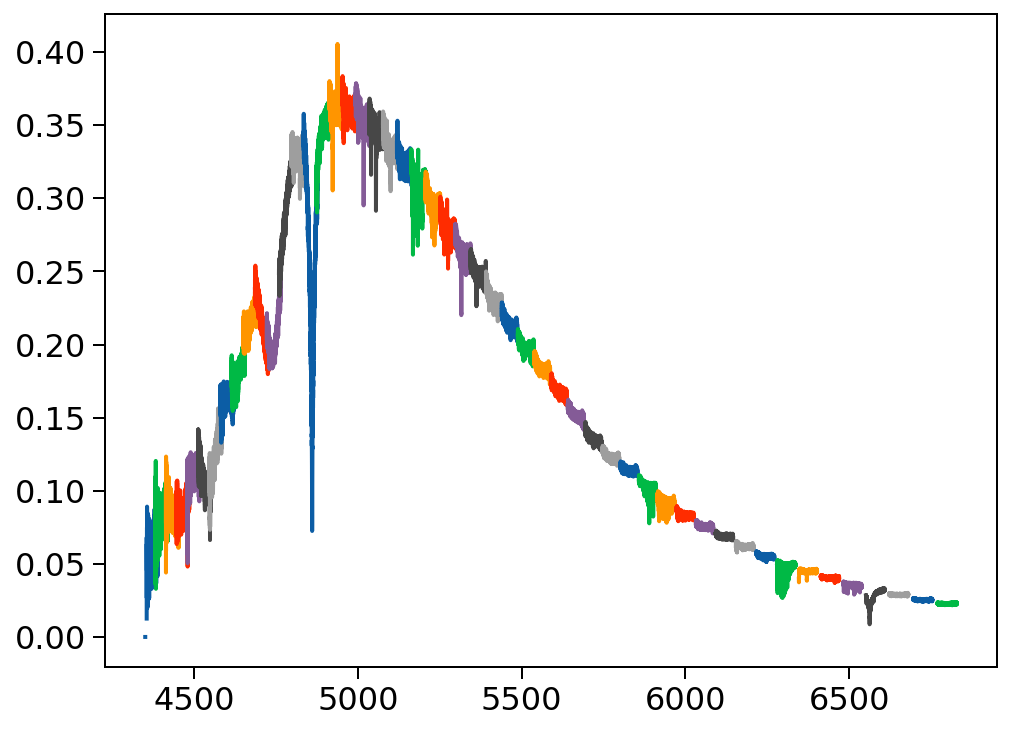

In [95]:
spec = all_spectra_files[10]

spec_data = pf.getdata(spec)
wav = spec_data[3,:,:]
flux = spec_data[0,:,:] / spec_data[2,:,:]
# flux += 1e6

for w, f in zip(wav, flux):
    ivars = np.ones_like(w)
#     mu = fit_continuum(w, f, ivars)
    plt.plot(w, f)
# plt.xlim(5360, 5370)

# plt.plot(wav.T, np.log(flux.T), c='red');
# plt.plot(wav.T, np.log(blaze.T), c='blue');


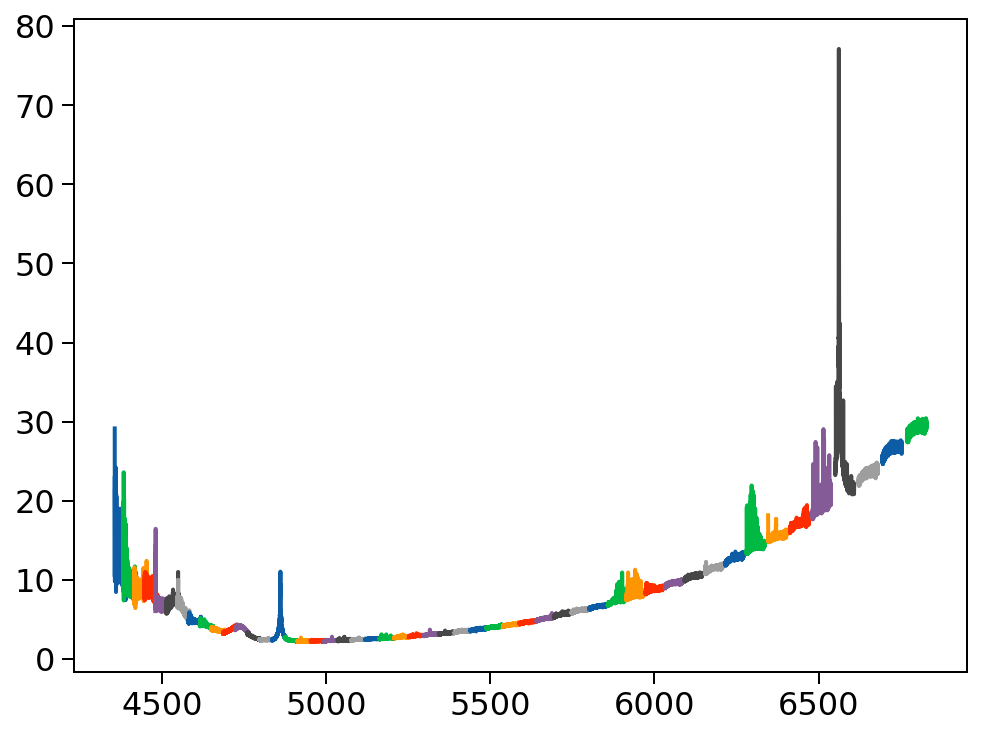

In [72]:
plt.plot(wav.T, (blaze / flux).T);

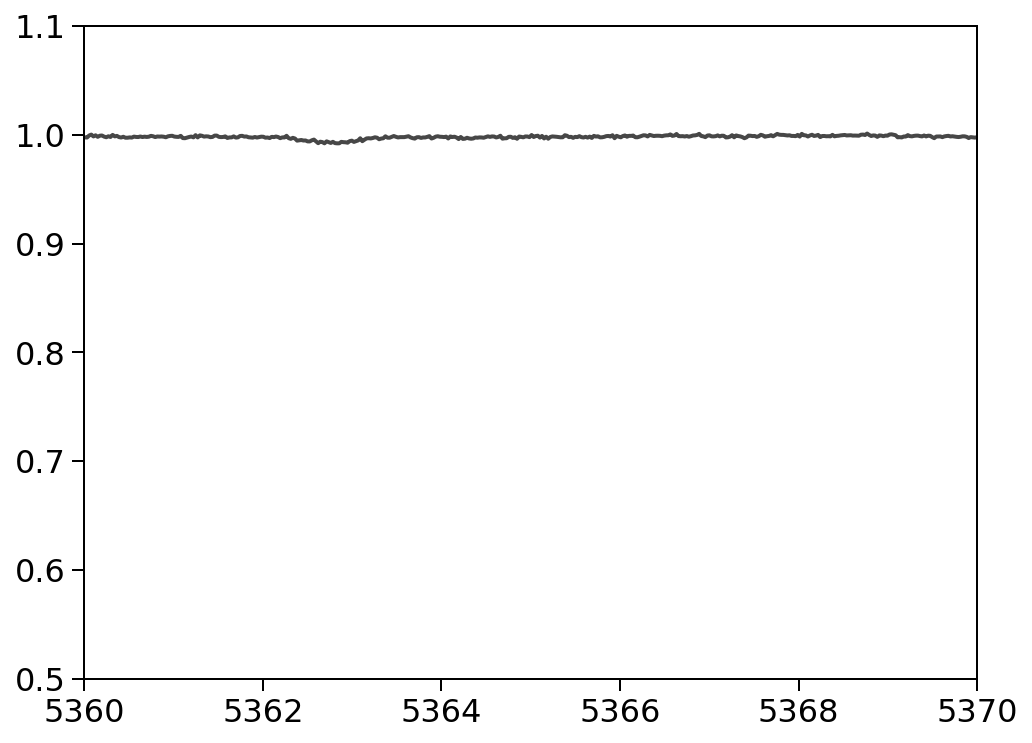

In [63]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
template = 0#np.geomspace(4400+3, 5436-3, 50000)

cleaned = []
for spec in all_spectra_files[:1]:
    spec_data = pf.getdata(spec)
    wav = spec_data[3,:,:]
    flux = (spec_data[0,:,:])  / spec_data[2,:,:])
#     plt.plot(wav.T, flux.T)
    plt.xlim(5360, 5370)
    plt.ylim(0.5, 1.1)
#     plt.xlim(np.log(5360), np.log(5370))
    clean = clean_spectrum(wav, flux, template)
# #     plt.plot(template, clean)
# cleaned = np.array(cleaned)

ValueError: x and y must have same first dimension, but have shapes (51, 2048) and (103277,)

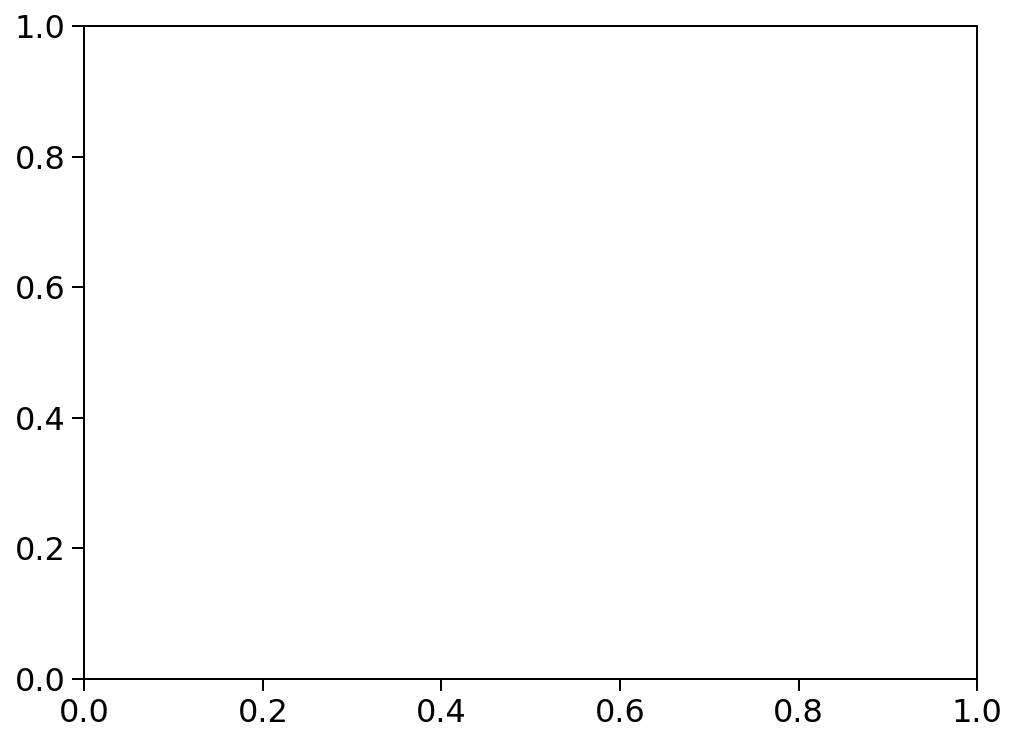

In [43]:
plt.plot(wav, clean)

In [62]:
wav.shape

(51, 2048)

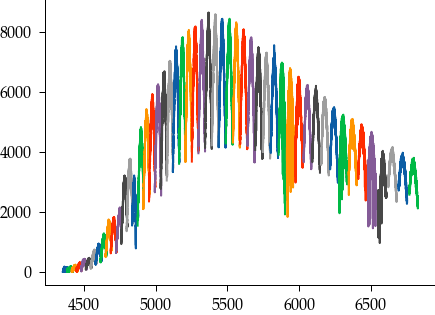

In [36]:
plt.plot(wav.T, flux.T);

In [7]:
wav, flux, meta = [], [], []
        for spectrum in all_spectra:
            spectra_data = pf.getdata( spectrum ) # Get the data
            meta.append(pf.getheader( spectrum )) # Get the full header
            wav.append(spectra_data[3,:,:])
            flux.append(spectra_data[0,:,:] / spectra_data[2,:,:])
        wav, flux = np.array(wav), np.array(flux)
        return Verse(wav, flux, meta)

In [8]:
get_spectra(all_spectra_files)

(array([[[4351.29484817, 4351.31631789, 4351.33778462, ...,
          4389.83788821, 4389.8544417 , 4389.8709932 ],
         [4382.61471472, 4382.63631885, 4382.65791998, ...,
          4421.40672825, 4421.42339081, 4421.44005137],
         [4414.38723864, 4414.4089801 , 4414.43071855, ...,
          4453.43339723, 4453.450171  , 4453.46694275],
         ...,
         [6621.93035676, 6621.9623826 , 6621.99440436, ...,
          6679.76151483, 6679.78637479, 6679.81123165],
         [6694.70175067, 6694.73412016, 6694.76648553, ...,
          6753.16136462, 6753.18649552, 6753.21162329],
         [6769.0901137 , 6769.12283408, 6769.15555029, ...,
          6828.19176298, 6828.21717087, 6828.24257558]],
 
        [[4351.30004524, 4351.32151345, 4351.34297868, ...,
          4389.84117697, 4389.85773117, 4389.87428338],
         [4382.61981278, 4382.64141566, 4382.66301554, ...,
          4421.41016686, 4421.42683011, 4421.44349137],
         [4414.39222291, 4414.41396335, 4414.43570078, 